# Check on the files exported by Equivital Qiosk
for RITMO

TODO

Plot and review measurements from equivital sensors as output by the Equivital Manager app.
(Every program produces different formated files and it's a pain.)

In [203]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# import heartpy as hp

from scipy.signal import butter,filtfilt
from scipy import interpolate
from scipy.interpolate import interp1d

## Definitions for data extraction

In [204]:
def min_dets(eq_file_loc): # for csv files output by the qiosk app
    filings = eq_file_loc.split('\\')
    file_name = filings[-1]
    f = file_name.split('-')
    Signal = f[0]
    DevName = f[1]#filings[-2]
    DevID = int(f[2])
    fileDate = int(f[3][:6]) # interpret as datetime datatype?
    # sometimes the session numbering fails and we get files with the same session number but an additiona _0 or _1
    # how to number this? What errors are producing these session numbers?
    if len(f[3].split('_'))==2: # we have an additional numbering to work into the sessions. :[
        Sessn1 = int(f[3].split('_')[0][6:8])
        Sessn2 = int(f[3].split('_')[1].split('.')[0])
        Session = (Sessn1+1)*100 + Sessn2+1 # yes this makes the session numbers huge out of nowhere, but it won't overlap with QIOSKs proper numbering that goes up to 99
    else:
        Session = int(f[3][6:8])
    fileSize = os.path.getsize(eq_file_loc)

    File_dets={'Signal':Signal, #f[-2].split('_')[-1],
       'DevName':DevName,
       'ID':DevID, 
       'Date':fileDate,
       'Session':Session,
       'FileName':file_name,
       'FileType':'csv',
       'FileSize': fileSize,
       'FullLoc':eq_file_loc}
    return File_dets

def data_dets(eq_file_loc): #rec_start = V['DateTime'].iloc[0]
    # this file pulls recording details from the file name and from inside file to aggregate all metadata
    filings = eq_file_loc.split('\\')
    file_name = filings[-1]
    f = file_name.split('-')
    Signal = f[0]
    DevName = f[1]#filings[-2]
    DevID = int(f[2])
    fileDate = int(f[3][:6]) # interpret as datetime datatype?
    # sometimes the session numbering fails and we get files with the same session number but an additiona _0 or _1
    # how to number this? What errors are producing these session numbers?
    if len(f[3].split('_'))==2: # we have an additional numbering to work into the sessions. :[
        Sessn1 = int(f[3].split('_')[0][6:8])
        Sessn2 = int(f[3].split('_')[1].split('.')[0])
        Session = (Sessn1+1)*100 + Sessn2+1 # yes this makes the session numbers huge out of nowhere, but it won't overlap with QIOSKs proper numbering that goes up to 99
    else:
        Session = int(f[3][6:8])
    fileSize = os.path.getsize(eq_file_loc)
    
    V = pd.read_csv(eq_file_loc,skipinitialspace=True)
    if len(V)==0:
        File_dets = []
        return File_dets
    else:
        V['DateTime'] = pd.to_datetime(V['DateTime'])
        rec_start = V['DateTime'].iloc[0]
        rec_end = V['DateTime'].iloc[-1]
        rec_dur=(rec_end-rec_start).total_seconds()
        Batt_start = V['BATTERY(mV)'].iloc[0]
        Batt_end = V['BATTERY(mV)'].iloc[-1]
        Batt_spend=(Batt_end-Batt_start)     
        
        a = V.loc[:,['SENSOR ID', 'SUBJECT ID', 'SUBJECT AGE', 'HR(BPM)',
           'HRC(%)', 'BELT OFF', 'LEAD OFF', 'MOTION', 'BODY POSITION']].mode().loc[0]
        DevNames = V.loc[:,'SUBJECT ID'].unique()

        File_dets={'Signal':Signal, #f[-2].split('_')[-1],
           'DevName':DevName,
           'ID':DevID, 
           'Date':fileDate,
           'Session':Session,
           'FileName':file_name,
           'FileType':'csv',
           'FileSize': fileSize,
           'RecStart':rec_start,
           'RecEnd':rec_end,
           'Duration':rec_dur,
           'BatteryStart':Batt_start,
           'BatteryEnd':Batt_end,
           'BatteryChange(mV)':Batt_spend,
           'FullLoc':eq_file_loc,
           'SubjectNames': DevNames}
        File_dets.update(a) # dic0.update(dic1)
        return File_dets

def test_plot_signals(V): # V is a qiosk file read into pandas
    if len(V)>2:
        V['DateTime'] = pd.to_datetime(V['DateTime'])
        W = V.select_dtypes(include=['int64','float64'])
        W.set_index(V['DateTime'],inplace=True)
        cols = W.columns
        # excerpt a minute of signal from the middle of the recording
        if V['DateTime'].iloc[-1]-V['DateTime'].iloc[0]>pd.to_timedelta(120,'s'):
            t1 =  V['DateTime'].iloc[int(len(V)/2)]
            t2 = t1+pd.to_timedelta(60,'s')
            X = W.loc[W.index>t1,:].copy()
            X = X.loc[X.index<t2,:].copy()
            for c in cols:
                fig, (ax1, ax2) = plt.subplots(1,2,figsize=[15,2])
                W[c].plot(ax=ax1)
                ax1.set_ylabel(c)
                X.loc[:,c].plot(ax=ax2)
                ax2.set_xlabel('60 seconds')
                plt.show()
        else:
            for c in cols:
                fig, (ax1) = plt.subplots(1,1,figsize=[15,2])
                W[c].plot(ax=ax1)
                ax1.set_ylabel(c)
                plt.show()
    else:
        print('Not enough data')
        
def test_plot_signals_interval(V,t1,t2): # V is a qiosk file read into pandas
    # its on you to be sure these time stamps are within the recording interval of the file
    if len(V)>2:
        V['DateTime'] = pd.to_datetime(V['DateTime'])
        W = V.select_dtypes(include=['int64','float64'])
        W.set_index(V['DateTime'],inplace=True)
        cols = W.columns
        X = W.loc[W.index>t1,:].copy()
        X = X.loc[X.index<t2,:].copy()
        for c in cols:
            fig, (ax1) = plt.subplots(1,1,figsize=[15,2])
            X.loc[:,c].plot(ax=ax1)
            ax1.set_ylabel(c)
            plt.show()
    else:
        print('Not enough data')
        
def matched_files(eq_file_loc,data_path):
    # from the location of a good file and the location of other files, retrieve the location of all matching files
    dfile = min_dets(eq_file_loc)
    
    # retrieve the files in that path that match 
    file_locs = []
    for root, dirs, files in os.walk(data_path):
        for file in files:
            if(file.lower().endswith(".csv")):
                file_locs.append(os.path.join(root,file))
    k=[]           
    for f in file_locs:
        File_dets=min_dets(f)#File_dets=min_dets_sem(f)
        k.append(File_dets)
    df_files=pd.DataFrame(data=k)

    match_fields = ['ID','DevName','Date','Session']

    matched_files = df_files.loc[df_files['ID'] == dfile['ID']]
    for mf in match_fields[1:]:
        matched_files = matched_files.loc[matched_files[mf] == dfile[mf]]



    return list(matched_files['FullLoc'])#+list(matched_files['SEMLoc'])
    

# Scan for DATA files
Check the usual spot that QIOSK deposits files for data files detailing recordings

In [205]:
path = "C:\\Users\\Public\\Documents\\Equivital\\Equivital Manager Wizard\\"#Extracted SEM Data\\" #"../Equivital/Equivital Manager Wizard/Extracted SEM Data/"
# os.listdir(path)

In [206]:
# find all the DATA files
file_locs = []
for root, dirs, files in os.walk(path):
    for file in files:
        if(file.lower().endswith(".csv")):
            if file.lower().startswith('data'):
                file_locs.append(os.path.join(root,file))
k=[]           
for f in file_locs:
    File_dets=data_dets(f)
    if File_dets:
        k.append(File_dets)
df_datafiles=pd.DataFrame(data=k)
#

In [207]:
# if you want, output a csv of recordings metadata
df_datafiles.to_csv('Present_Qiosk_files.csv')

In [208]:
# key categories to structure of Qiosk output DATA files
print('Number of DATA files: '+ str(len(df_datafiles)))
print(df_datafiles['ID'].unique())
print(df_datafiles['Date'].unique())

Number of DATA files: 229
[3420415 5022176 3420426 5022076 5022010 5022155 5022100 5022098 5022173
 5022077 5022156 5022297 5022143 5022202 5022161 5023926 5022009 5022006
 5022117 5022073 5022152 5022256 5022101 5022142 5022207 5022131 5022163
 5022002 5022240 5022292 5022051 5022184 5022026 5022204 5022154 5022238
 5022244 5022149 3420755 5022127 5022031 5022062 5022104 5022234 5022179
 5022057 5022203 5022151 5022245 3420456 5022166 5022285 5022027 5022241
 5022110 5022247 5022198 5022193 5022222 5022058 3420427 5022141 5022164
 5022060 5022138 5022126 5022139 5022050 5022281 5022299]
[230126 230127 230128 230201 230130 230131 230117 230118 230119 230120
 230123 230124 230125]


# Review recordings from a specific device and recording time
First preview files from a specific device (or other feild), then find the other signal files that match that Data files

In [209]:
# DATA files from one device, by the more reliable device ID numbr
devN = 3420755
#s_files=df_datafiles.loc[df_datafiles['ID'] == devN,:] 
s_files=df_datafiles.loc[df_datafiles['Date'] == 230131,:]

# t = pd.to_datetime('2023-01-27 10:30:00.00+0000')# V['DateTime'].iloc[int(len(V)/2)]
# s_files=s_files.loc[s_files['RecStart']< t,:] 
s_files

,Signal,DevName,ID,Date,Session,FileName,FileType,FileSize,RecStart,RecEnd,...,SubjectNames,SENSOR ID,SUBJECT ID,SUBJECT AGE,HR(BPM),HRC(%),BELT OFF,LEAD OFF,MOTION,BODY POSITION
38,DATA,Pilot 42,5022143,230131,0,DATA-Pilot 42-5022143-23013100.CSV,csv,186,2023-01-31 10:18:57+00:00,2023-01-31 10:18:57+00:00,...,[Pilot 42],5022143.0,Pilot 42,NaN,14.0,94.0,1.0,1.0,Stationary,Side
91,DATA,Pilot_1,3420755,230131,0,DATA-Pilot_1-3420755-23013100.CSV,csv,12267,2023-01-31 14:38:04+00:00,2023-01-31 15:15:49+00:00,...,[Pilot_1],3420755.0,Pilot_1,NaN,79.0,95.0,0.0,1.0,Stationary,Upright


In [210]:
fileN = 91
eq_file_loc = s_files.loc[fileN,'FullLoc']
print(s_files.loc[fileN,:])

Signal                                                            DATA
DevName                                                        Pilot_1
ID                                                             3420755
Date                                                            230131
Session                                                              0
FileName                             DATA-Pilot_1-3420755-23013100.CSV
FileType                                                           csv
FileSize                                                         12267
RecStart                                     2023-01-31 14:38:04+00:00
RecEnd                                       2023-01-31 15:15:49+00:00
Duration                                                        2265.0
BatteryStart                                                      4117
BatteryEnd                                                        4094
BatteryChange(mV)                                                  -23
FullLo

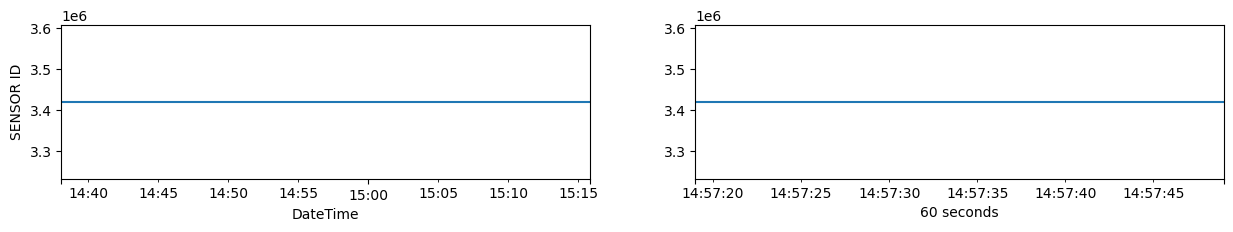

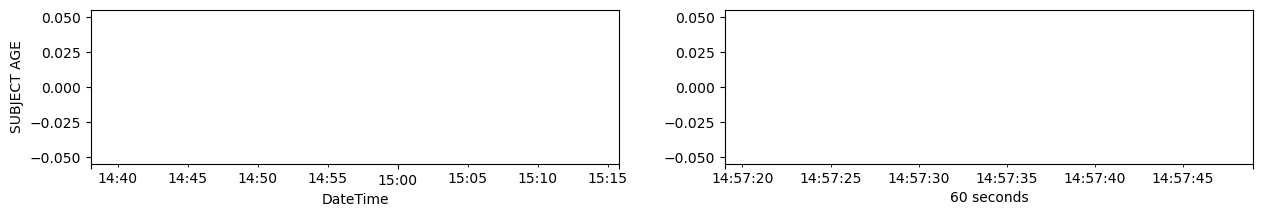

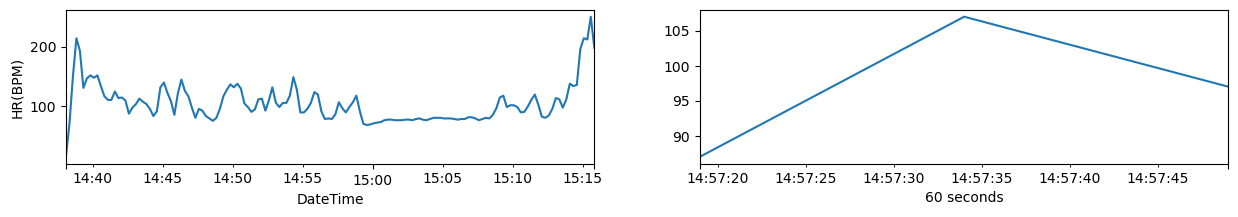

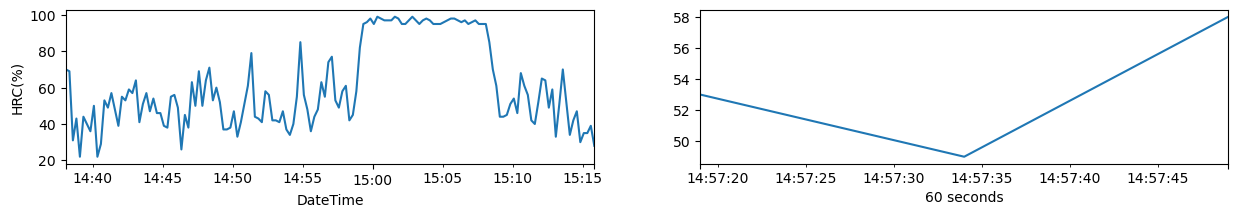

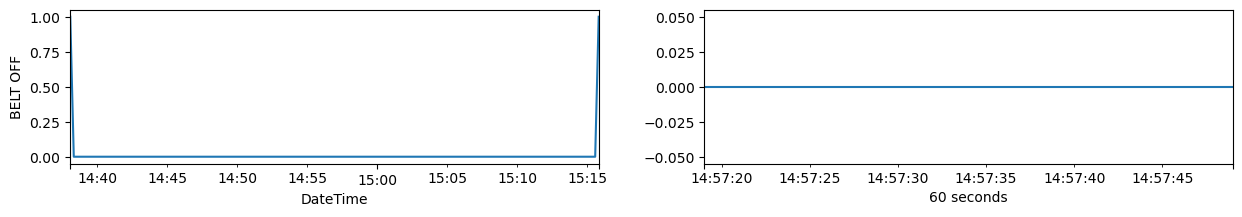

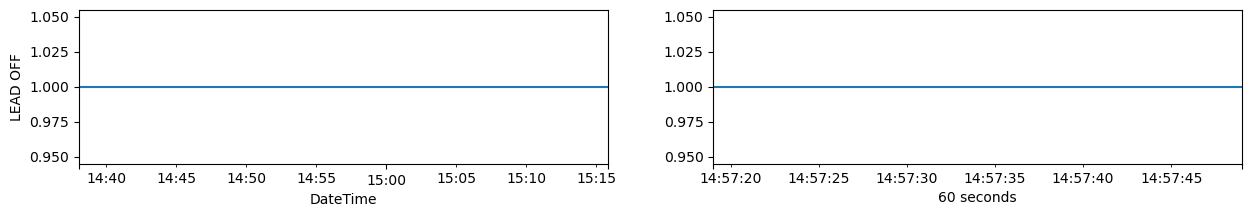

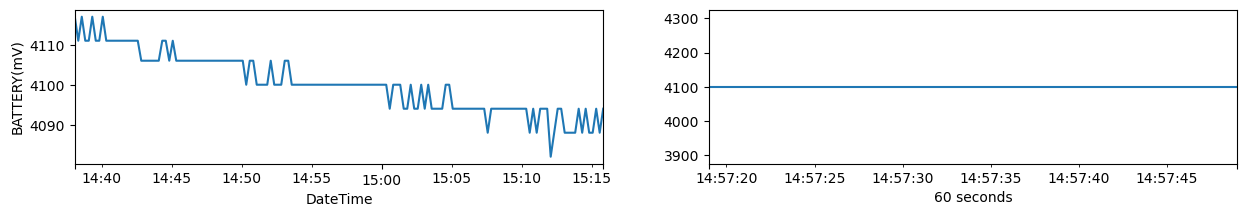

,DateTime,SENSOR ID,SUBJECT ID,SUBJECT AGE,HR(BPM),HRC(%),BELT OFF,LEAD OFF,MOTION,BODY POSITION,BATTERY(mV)
0,2023-01-31 14:38:04+00:00,3420755,Pilot_1,NaN,16,70,1,1,MovingFast,Supine,4117
1,2023-01-31 14:38:19+00:00,3420755,Pilot_1,NaN,70,69,0,1,MovingSlowly,Side,4111
2,2023-01-31 14:38:34+00:00,3420755,Pilot_1,NaN,150,31,0,1,MovingSlowly,Prone,4117
3,2023-01-31 14:38:49+00:00,3420755,Pilot_1,NaN,214,43,0,1,MovingSlowly,Upright,4111
4,2023-01-31 14:39:04+00:00,3420755,Pilot_1,NaN,193,22,0,1,MovingSlowly,Upright,4111


In [211]:
# Plot a quick view of the DATA file numeric fields
V = pd.read_csv(eq_file_loc,skipinitialspace=True)
test_plot_signals(V)
V.iloc[:5]

Now grab all the files from that recording and presente a test plot of each, full and middle minute


C:\Users\Public\Documents\Equivital\Equivital Manager Wizard\Extracted SEM Data\Pilot_1\DATA-Pilot_1-3420755-23013100.CSV


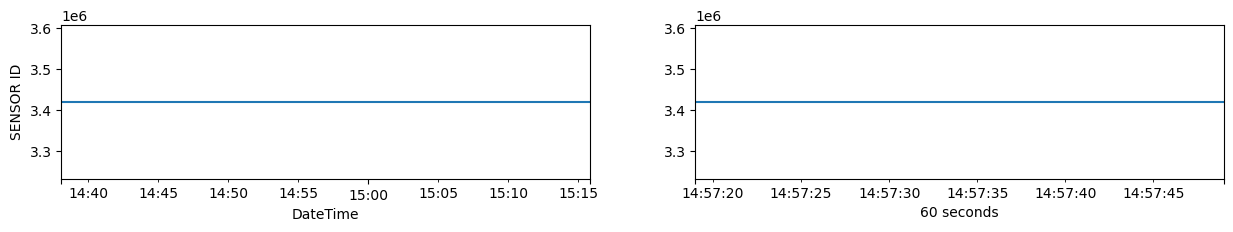

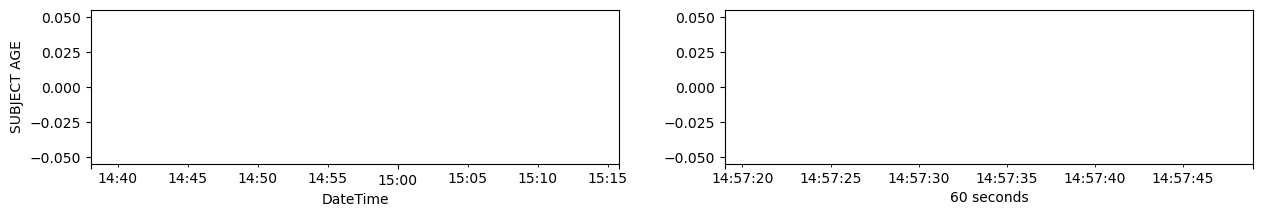

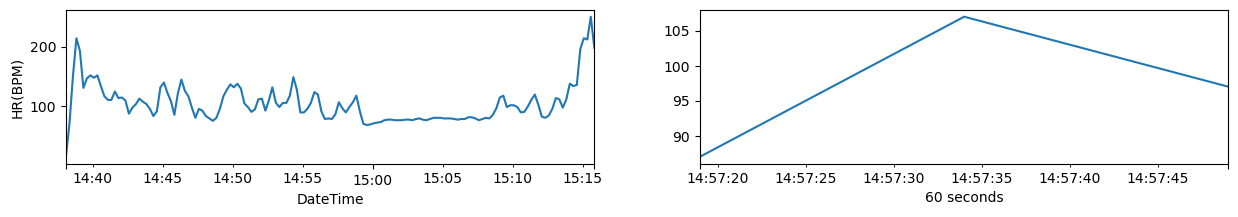

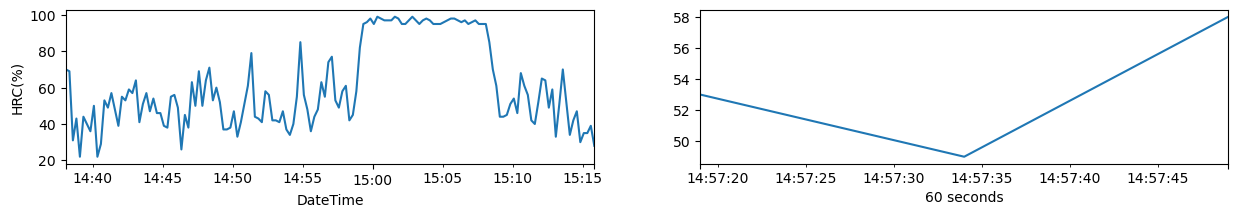

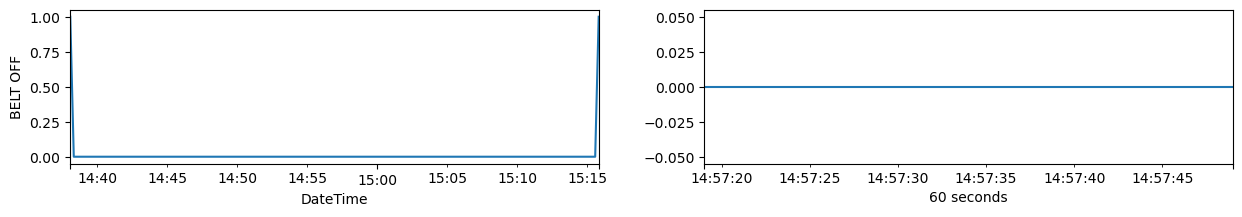

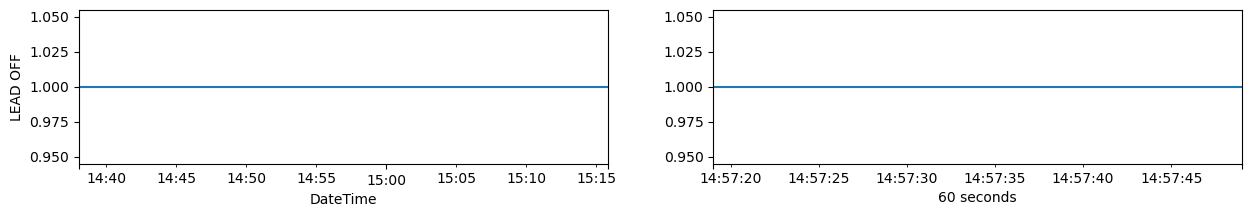

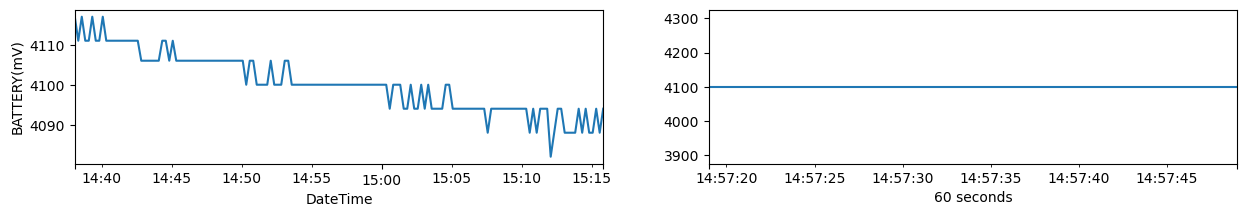

C:\Users\Public\Documents\Equivital\Equivital Manager Wizard\Extracted SEM Data\Pilot_1\ECG-Pilot_1-3420755-23013100.csv


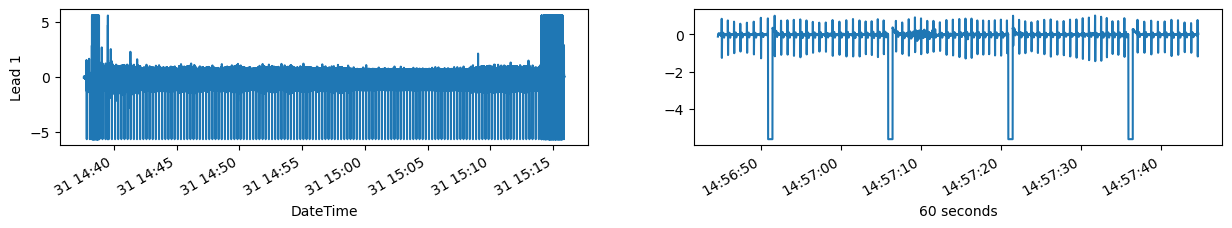

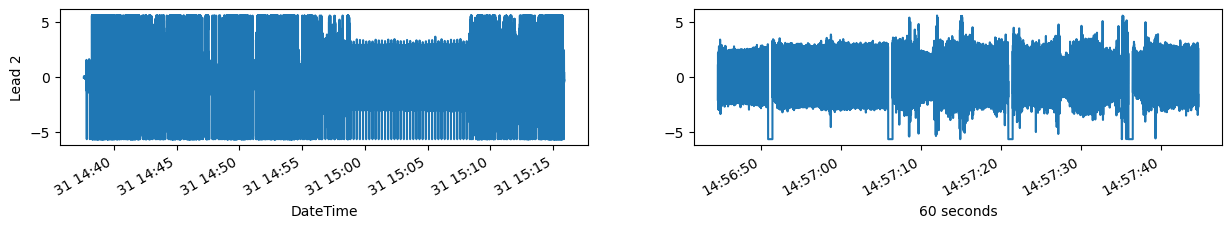

C:\Users\Public\Documents\Equivital\Equivital Manager Wizard\Extracted SEM Data\Pilot_1\RESPACC-Pilot_1-3420755-23013100.CSV


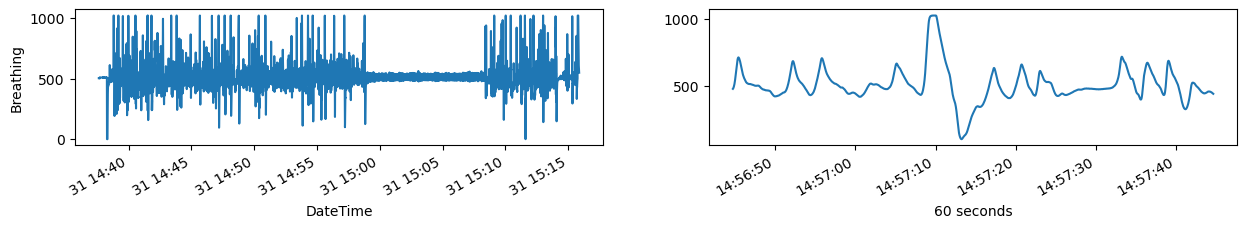

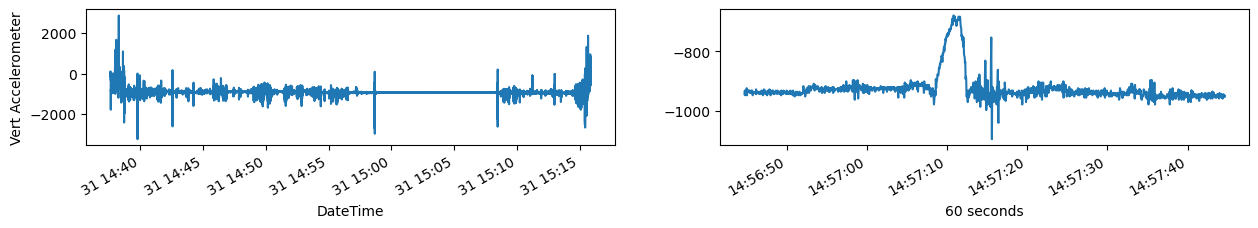

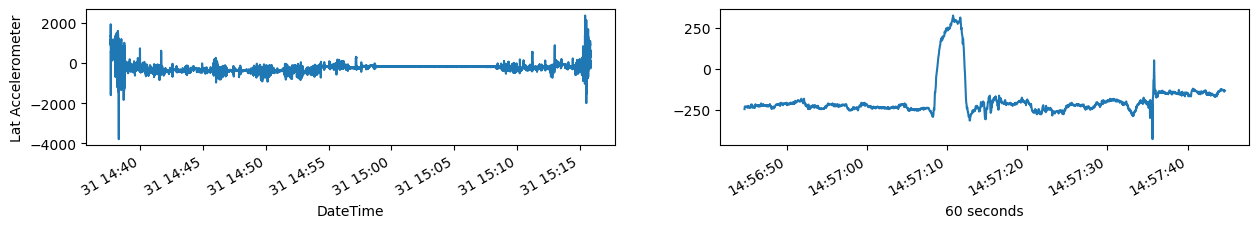

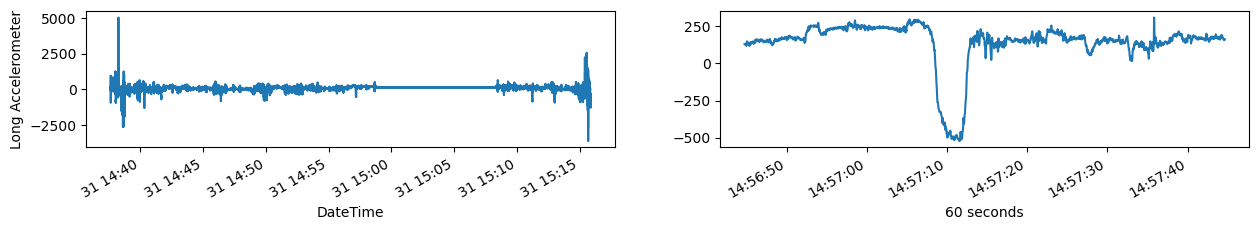

C:\Users\Public\Documents\Equivital\Equivital Manager Wizard\Extracted SEM Data\Pilot_1\RR-Pilot_1-3420755-23013100.CSV


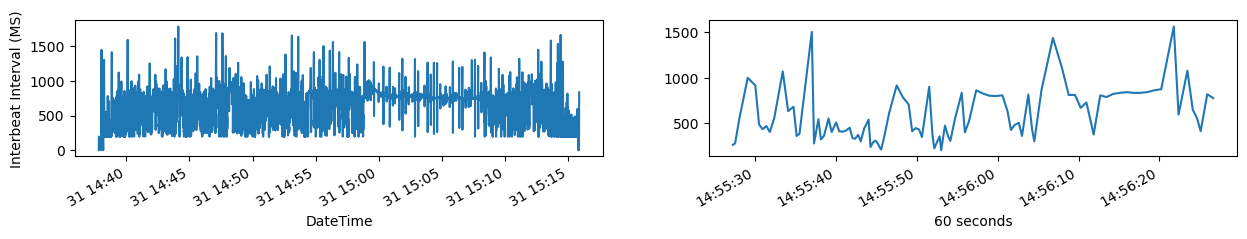

In [212]:
matched = matched_files(s_files.loc[fileN,'FullLoc'],path) # outputs locations of csv 
for eq_file_loc in matched:
    print(eq_file_loc)
    V = pd.read_csv(eq_file_loc,skipinitialspace=True)
    test_plot_signals(V)

# Plot all signals recorded at specific time

In [174]:
#fileN = 
eq_file_loc = df_datafiles.loc[fileN,'FullLoc']
print(df_datafiles.loc[fileN,:])

Signal                                                            DATA
DevName                                             Bluetooth_Tester_1
ID                                                             3420415
Date                                                            230201
Session                                                              0
FileName                  DATA-Bluetooth_Tester_1-3420415-23020100.CSV
FileType                                                           csv
FileSize                                                          8325
RecStart                                     2023-02-01 09:04:22+00:00
RecEnd                                       2023-02-01 09:26:52+00:00
Duration                                                        1350.0
BatteryStart                                                      4117
BatteryEnd                                                        4088
BatteryChange(mV)                                                  -29
FullLo

In [217]:
# the times at which you want to check the recording
# note: make sure you set the times to within the recording interval for that file!!
t1 = pd.to_datetime('2023-01-31 15:05:00.00+0000')# V['DateTime'].iloc[int(len(V)/2)]
t2 = t1+pd.to_timedelta(30,'s')
[t1,t2]

[Timestamp('2023-01-31 15:05:00+0000', tz='UTC'),
 Timestamp('2023-01-31 15:05:30+0000', tz='UTC')]

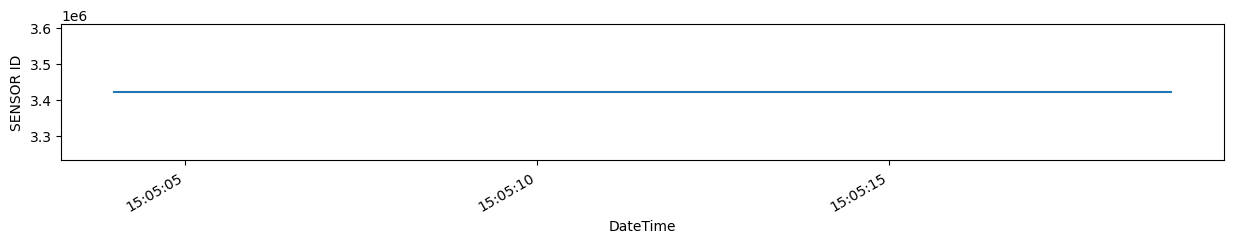

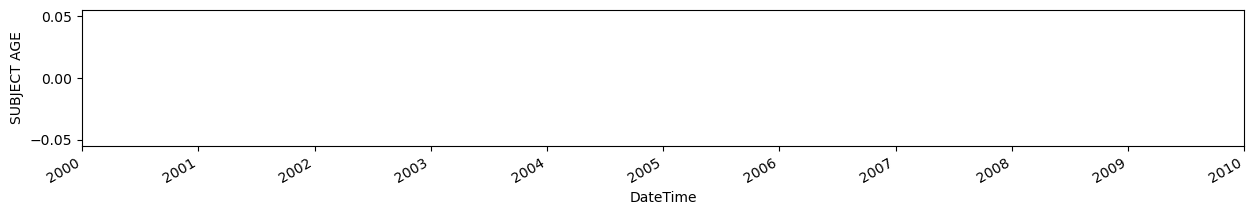

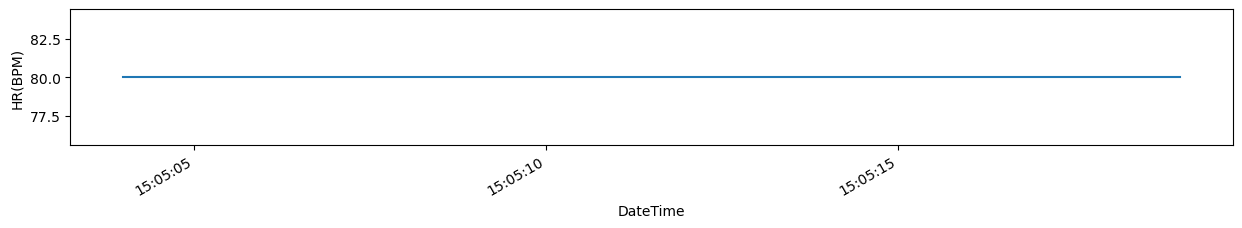

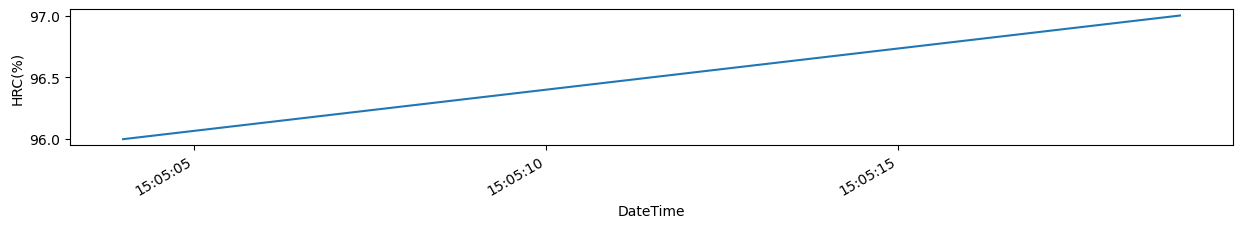

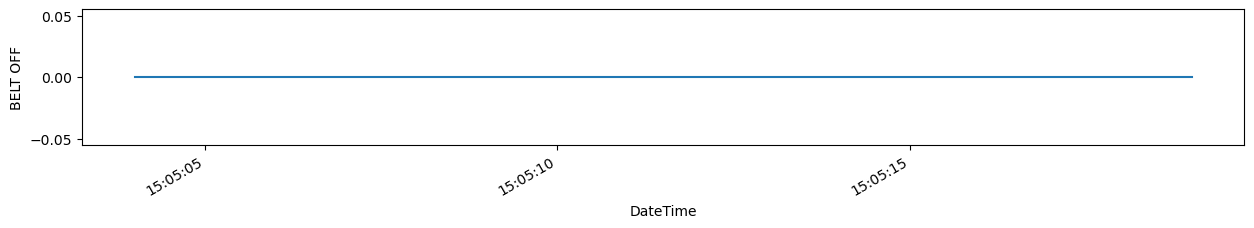

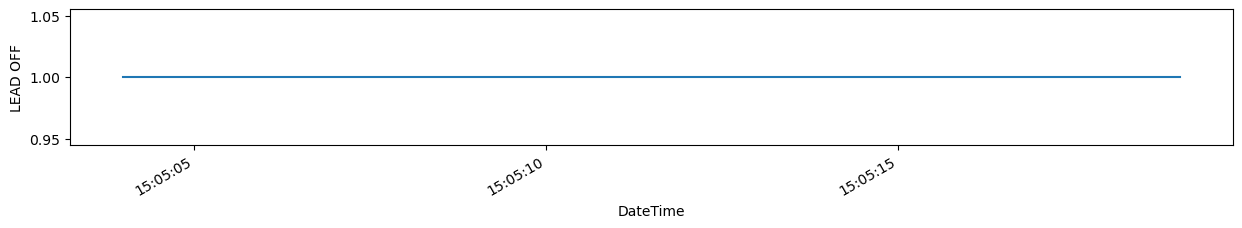

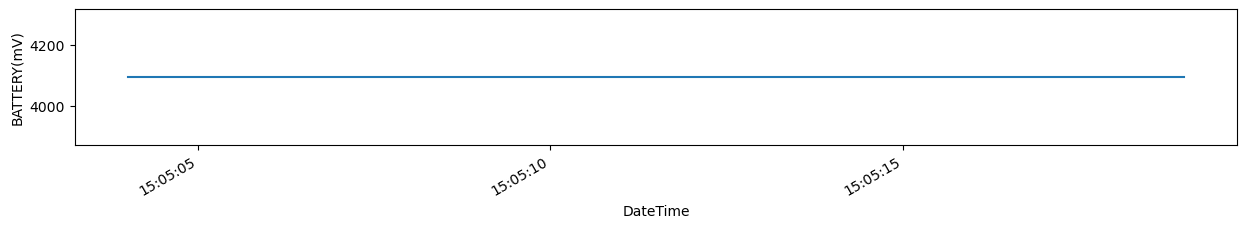

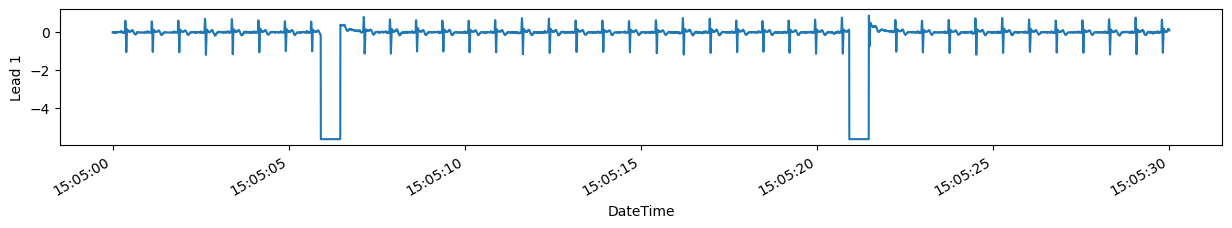

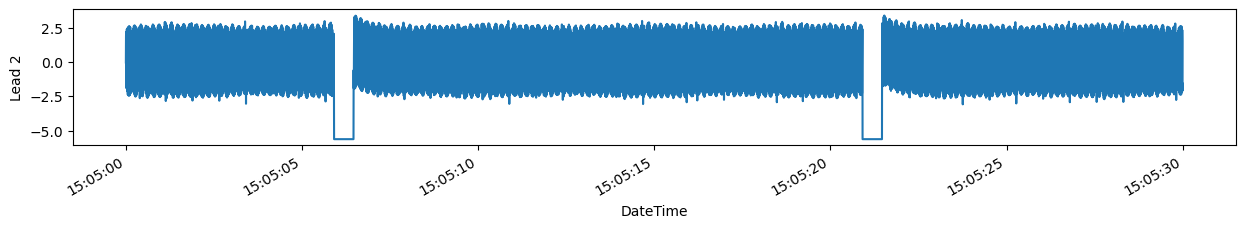

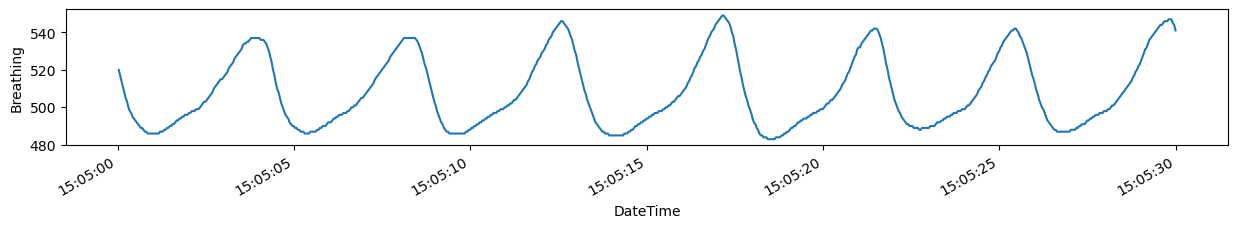

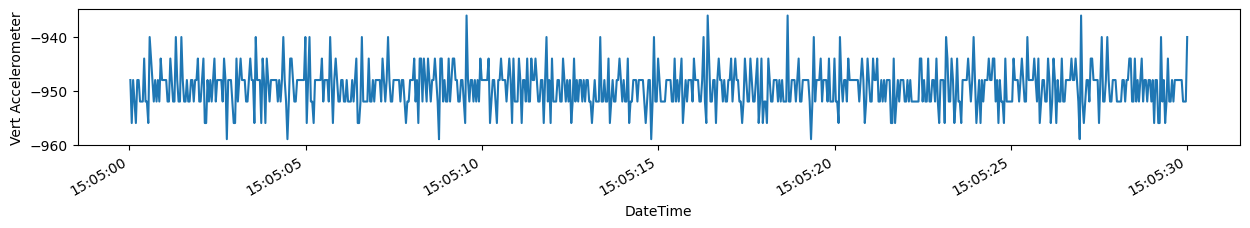

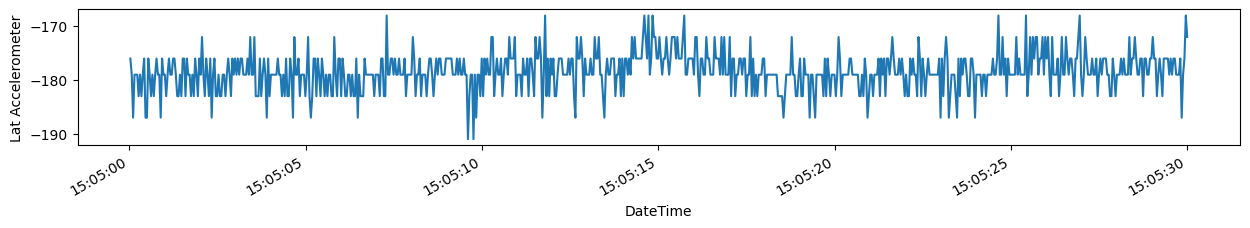

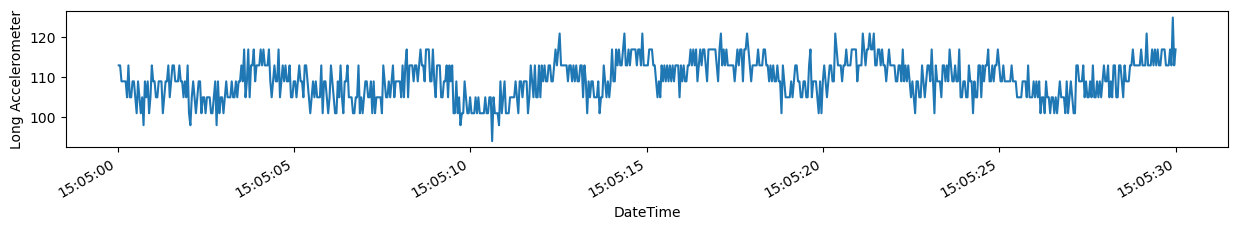

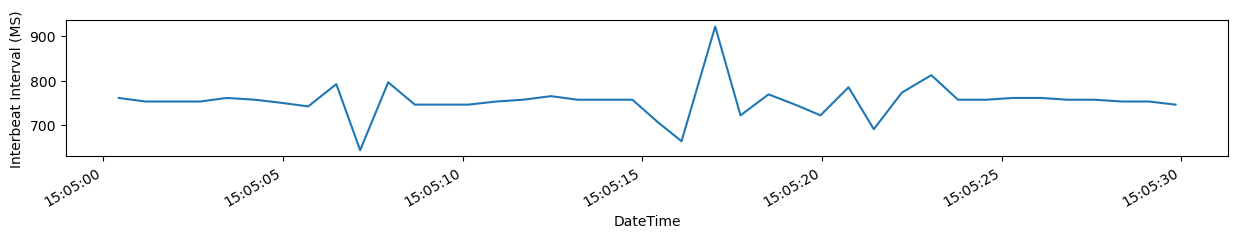

In [218]:
for eq_file_loc in matched:
    V = pd.read_csv(eq_file_loc,skipinitialspace=True)
#     print(V.iloc[:2,:])
    test_plot_signals_interval(V,t1,t2)